# 1. Import Dependencies

In [335]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout, SimpleRNN
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# 2. Keypoints using MP Holistic

In [336]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [337]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [338]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [339]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [ ]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# 3. Setup Folders for data

In [340]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 0

# 4. Create Dataset

### *Optional if dont have training set*

In [ ]:
MP_DATA_PATH = os.path.join(os.getcwd(),"MP_Data")  # Change this to your desired MP_Data path

# Create MP_Data directory if it doesn't exist
if not os.path.exists(MP_DATA_PATH):
    os.makedirs(MP_DATA_PATH)

for action in actions:
    action_path = os.path.join(MP_DATA_PATH, action)

    # Create action directory if it doesn't exist
    if not os.path.exists(action_path):
        os.makedirs(action_path)

    # Create subdirectories based on the logic in your previous script
    for sequence in range(1, no_sequences + 2):
        new_dir = os.path.join(action_path, str(sequence))

        # Check if the directory already exists
        if not os.path.exists(new_dir):
            os.makedirs(new_dir)


In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence+1), str(frame_num+1))
                np.save(npy_path, keypoints)
                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

### *If you have training set or once you run code for getting training set*

In [341]:
label_map = {label:num for num, label in enumerate(actions)}

In [342]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [343]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence+1), "{}.npy".format(frame_num+1)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [344]:
X = np.array(sequences)

In [345]:
y = to_categorical(labels).astype(int)

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 5. Build and Train Networks

In [347]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

### 5.1 GRU with Dropout

In [254]:
model = Sequential()
model.add(GRU(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(Dropout(.3))
model.add(GRU(128, return_sequences=True, activation='relu'))
model.add(Dropout(.3))
model.add(GRU(64, return_sequences=False, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [255]:
with tf.device("/cpu:0"):
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    history = model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback], validation_data=(X_test, y_test))

Epoch 1/500


2023-11-29 12:37:01.161070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 253ms/step - loss: 1.1060 - categorical_accuracy: 0.3333 - val_loss: 1.0952 - val_categorical_accuracy: 0.3333
Epoch 2/500


2023-11-29 12:37:02.381444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 153ms/step - loss: 1.1130 - categorical_accuracy: 0.3472 - val_loss: 1.0885 - val_categorical_accuracy: 0.3333
Epoch 3/500
3/3 [==============================] - 0s 106ms/step - loss: 1.0907 - categorical_accuracy: 0.3472 - val_loss: 1.0782 - val_categorical_accuracy: 0.3889
Epoch 4/500
3/3 [==============================] - 0s 122ms/step - loss: 1.0943 - categorical_accuracy: 0.3056 - val_loss: 1.0726 - val_categorical_accuracy: 0.5556
Epoch 5/500
3/3 [==============================] - 0s 141ms/step - loss: 1.0886 - categorical_accuracy: 0.4306 - val_loss: 1.0666 - val_categorical_accuracy: 0.6111
Epoch 6/500
3/3 [==============================] - 0s 142ms/step - loss: 1.0963 - categorical_accuracy: 0.4028 - val_loss: 1.0503 - val_categorical_accuracy: 0.6111
Epoch 7/500
3/3 [==============================] - 0s 136ms/step - loss: 1.0650 - categorical_accuracy: 0.5278 - val_loss: 0.9881 - val_categorical_accuracy: 0.5000
Epoch 8/500
3/3 [=====

### 5.2 Simple RNN with Dropout

In [256]:
model2 = Sequential()
model2.add(SimpleRNN(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model2.add(Dropout(.3))
model2.add(SimpleRNN(128, return_sequences=True, activation='relu'))
model2.add(Dropout(.3))
model2.add(SimpleRNN(64, return_sequences=False, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(.3))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(actions.shape[0], activation='softmax'))

In [257]:
with tf.device("/cpu:0"):
    model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    history2 = model2.fit(X_train, y_train, epochs=500, callbacks=[tb_callback], validation_data=(X_test, y_test))

Epoch 1/500


2023-11-29 12:39:37.375187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 158ms/step - loss: 1.2030 - categorical_accuracy: 0.3056 - val_loss: 1.1030 - val_categorical_accuracy: 0.2778
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 1.1343 - categorical_accuracy: 0.3750

2023-11-29 12:39:38.087341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 85ms/step - loss: 1.1266 - categorical_accuracy: 0.3333 - val_loss: 1.1076 - val_categorical_accuracy: 0.2778
Epoch 3/500
3/3 [==============================] - 0s 71ms/step - loss: 1.2004 - categorical_accuracy: 0.2917 - val_loss: 1.0951 - val_categorical_accuracy: 0.2778
Epoch 4/500
3/3 [==============================] - 0s 70ms/step - loss: 1.1099 - categorical_accuracy: 0.3611 - val_loss: 1.0887 - val_categorical_accuracy: 0.3889
Epoch 5/500
3/3 [==============================] - 0s 70ms/step - loss: 1.1040 - categorical_accuracy: 0.4167 - val_loss: 1.0836 - val_categorical_accuracy: 0.3889
Epoch 6/500
3/3 [==============================] - 0s 72ms/step - loss: 1.1308 - categorical_accuracy: 0.3194 - val_loss: 1.0859 - val_categorical_accuracy: 0.6111
Epoch 7/500
3/3 [==============================] - 0s 86ms/step - loss: 1.1286 - categorical_accuracy: 0.3750 - val_loss: 1.1073 - val_categorical_accuracy: 0.2778
Epoch 8/500
3/3 [===========

### 5.3 LSTM with Dropout

In [258]:
model3 = Sequential()
model3.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model3.add(Dropout(.3))
model3.add(LSTM(128, return_sequences=True, activation='relu'))
model3.add(Dropout(.3))
model3.add(LSTM(64, return_sequences=False, activation='relu'))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(.3))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(.3))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(actions.shape[0], activation='softmax'))

In [259]:
with tf.device("/cpu:0"):
    model3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    history3 = model3.fit(X_train, y_train, epochs=500, callbacks=[tb_callback], validation_data=(X_test, y_test))

Epoch 1/500


2023-11-29 12:41:27.893228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 201ms/step - loss: 1.2488 - categorical_accuracy: 0.3333 - val_loss: 1.5071 - val_categorical_accuracy: 0.3333
Epoch 2/500


2023-11-29 12:41:28.834616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 98ms/step - loss: 1.6905 - categorical_accuracy: 0.3333 - val_loss: 1.2404 - val_categorical_accuracy: 0.2778
Epoch 3/500
3/3 [==============================] - 0s 98ms/step - loss: 1.3211 - categorical_accuracy: 0.2778 - val_loss: 1.1200 - val_categorical_accuracy: 0.2778
Epoch 4/500
3/3 [==============================] - 0s 98ms/step - loss: 1.1595 - categorical_accuracy: 0.2917 - val_loss: 1.0419 - val_categorical_accuracy: 0.2778
Epoch 5/500
3/3 [==============================] - 0s 95ms/step - loss: 1.0865 - categorical_accuracy: 0.2917 - val_loss: 1.0864 - val_categorical_accuracy: 0.2778
Epoch 6/500
3/3 [==============================] - 0s 97ms/step - loss: 1.1225 - categorical_accuracy: 0.3472 - val_loss: 0.9861 - val_categorical_accuracy: 0.2778
Epoch 7/500
3/3 [==============================] - 0s 96ms/step - loss: 1.0320 - categorical_accuracy: 0.3472 - val_loss: 0.9857 - val_categorical_accuracy: 0.2778
Epoch 8/500
3/3 [===========

### 5.4 Accuracy, Validation Accuracy, Loss graphs for Networks with Dropout

Text(0.5, 1.0, 'Accuracy per Epoch with dropout')

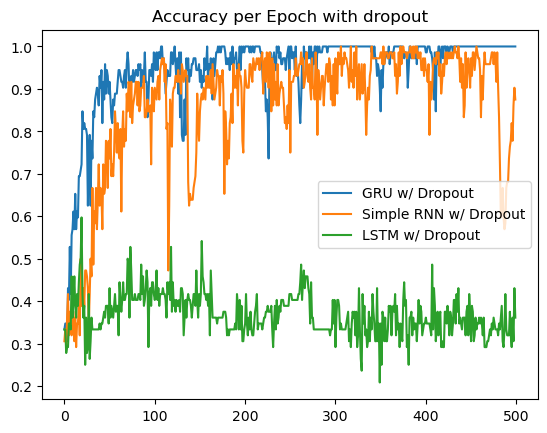

In [349]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history3.history['categorical_accuracy'])
plt.legend(['GRU w/ Dropout', 'Simple RNN w/ Dropout', 'LSTM w/ Dropout'])
plt.title('Accuracy per Epoch with dropout')

Text(0.5, 1.0, 'Validation Accuracy per Epoch with dropout')

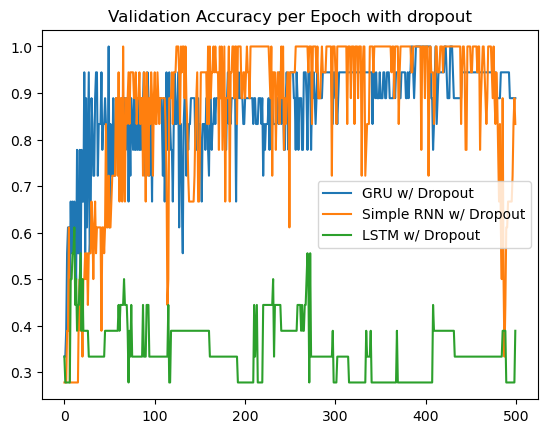

In [350]:
plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.plot(history3.history['val_categorical_accuracy'])
plt.legend(['GRU w/ Dropout', 'Simple RNN w/ Dropout', 'LSTM w/ Dropout'])
plt.title('Validation Accuracy per Epoch with dropout')

Text(0.5, 1.0, 'loss per Epoch with dropout')

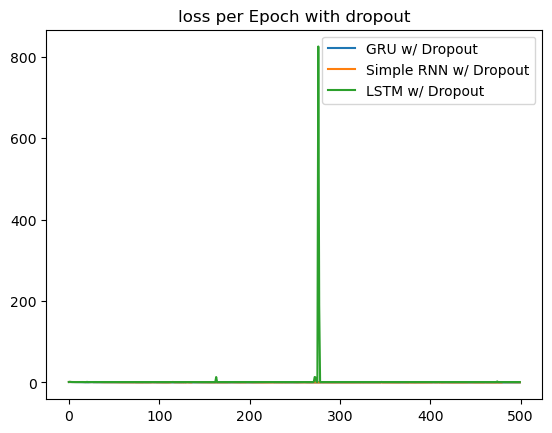

In [351]:
plt.plot(history.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.legend(['GRU w/ Dropout', 'Simple RNN w/ Dropout', 'LSTM w/ Dropout'])
plt.title('loss per Epoch with dropout')

### 5.5 GRU without Dropout

In [263]:
model4 = Sequential()
model4.add(GRU(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model4.add(GRU(128, return_sequences=True, activation='relu'))
model4.add(GRU(64, return_sequences=False, activation='relu'))
model4.add(Dense(256, activation='relu'))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(actions.shape[0], activation='softmax'))

In [264]:
with tf.device("/cpu:0"):
    model4.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    history4 = model4.fit(X_train, y_train, epochs=500, callbacks=[tb_callback], validation_data=(X_test, y_test))

Epoch 1/500


2023-11-29 12:43:57.840779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 211ms/step - loss: 1.1004 - categorical_accuracy: 0.3333 - val_loss: 1.0950 - val_categorical_accuracy: 0.3889
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 1.0934 - categorical_accuracy: 0.4062

2023-11-29 12:43:58.848704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 91ms/step - loss: 1.1012 - categorical_accuracy: 0.3194 - val_loss: 1.0913 - val_categorical_accuracy: 0.2778
Epoch 3/500
3/3 [==============================] - 0s 90ms/step - loss: 1.0872 - categorical_accuracy: 0.3472 - val_loss: 1.1049 - val_categorical_accuracy: 0.2778
Epoch 4/500
3/3 [==============================] - 0s 90ms/step - loss: 1.0984 - categorical_accuracy: 0.3472 - val_loss: 1.0845 - val_categorical_accuracy: 0.2778
Epoch 5/500
3/3 [==============================] - 0s 88ms/step - loss: 1.0663 - categorical_accuracy: 0.3472 - val_loss: 1.0547 - val_categorical_accuracy: 0.2778
Epoch 6/500
3/3 [==============================] - 0s 88ms/step - loss: 1.0304 - categorical_accuracy: 0.3472 - val_loss: 1.0106 - val_categorical_accuracy: 0.2778
Epoch 7/500
3/3 [==============================] - 0s 90ms/step - loss: 0.9794 - categorical_accuracy: 0.4583 - val_loss: 0.9382 - val_categorical_accuracy: 0.3333
Epoch 8/500
3/3 [===========

### 5.6 Simple RNN without Dropout

In [265]:
model5 = Sequential()
model5.add(SimpleRNN(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model5.add(SimpleRNN(128, return_sequences=True, activation='relu'))
model5.add(SimpleRNN(64, return_sequences=False, activation='relu'))
model5.add(Dense(256, activation='relu'))
model5.add(Dense(128, activation='relu'))
model5.add(Dense(64, activation='relu'))
model5.add(Dense(actions.shape[0], activation='softmax'))

In [266]:
with tf.device("/cpu:0"):
    model5.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    history5 = model5.fit(X_train, y_train, epochs=500, callbacks=[tb_callback], validation_data=(X_test, y_test))

Epoch 1/500


2023-11-29 12:46:31.221893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 164ms/step - loss: 1.1570 - categorical_accuracy: 0.2639 - val_loss: 1.0985 - val_categorical_accuracy: 0.2778
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 1.1214 - categorical_accuracy: 0.2500

2023-11-29 12:46:31.940683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 89ms/step - loss: 1.1026 - categorical_accuracy: 0.2917 - val_loss: 1.1095 - val_categorical_accuracy: 0.2778
Epoch 3/500
3/3 [==============================] - 0s 69ms/step - loss: 1.0973 - categorical_accuracy: 0.3333 - val_loss: 1.0748 - val_categorical_accuracy: 0.2778
Epoch 4/500
3/3 [==============================] - 0s 70ms/step - loss: 1.0969 - categorical_accuracy: 0.3472 - val_loss: 1.0670 - val_categorical_accuracy: 0.3333
Epoch 5/500
3/3 [==============================] - 0s 71ms/step - loss: 1.1024 - categorical_accuracy: 0.3750 - val_loss: 1.1389 - val_categorical_accuracy: 0.3333
Epoch 6/500
3/3 [==============================] - 0s 72ms/step - loss: 1.1431 - categorical_accuracy: 0.3750 - val_loss: 1.0965 - val_categorical_accuracy: 0.3333
Epoch 7/500
3/3 [==============================] - 0s 77ms/step - loss: 1.0790 - categorical_accuracy: 0.3889 - val_loss: 1.0778 - val_categorical_accuracy: 0.6111
Epoch 8/500
3/3 [===========

### 5.7 LSTM without Dropout

In [271]:
model6 = Sequential()
model6.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model6.add(LSTM(128, return_sequences=True, activation='relu'))
model6.add(LSTM(64, return_sequences=False, activation='relu'))
model6.add(Dense(256, activation='relu'))
model6.add(Dense(128, activation='relu'))
model6.add(Dense(64, activation='relu'))
model6.add(Dense(actions.shape[0], activation='softmax'))

In [272]:
with tf.device("/cpu:0"):
    model6.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    history6 = model6.fit(X_train, y_train, epochs=500, callbacks=[tb_callback], validation_data=(X_test, y_test))

Epoch 1/500


2023-11-29 12:50:49.662647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 218ms/step - loss: 2.4976 - categorical_accuracy: 0.3333 - val_loss: 4.6786 - val_categorical_accuracy: 0.3333
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 4.0923 - categorical_accuracy: 0.3125

2023-11-29 12:50:50.667008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 94ms/step - loss: 2.5766 - categorical_accuracy: 0.2917 - val_loss: 1.5552 - val_categorical_accuracy: 0.2778
Epoch 3/500
3/3 [==============================] - 0s 100ms/step - loss: 2.0680 - categorical_accuracy: 0.2778 - val_loss: 1.3367 - val_categorical_accuracy: 0.3333
Epoch 4/500
3/3 [==============================] - 0s 97ms/step - loss: 1.5073 - categorical_accuracy: 0.3750 - val_loss: 3.4376 - val_categorical_accuracy: 0.2222
Epoch 5/500
3/3 [==============================] - 0s 104ms/step - loss: 2.5070 - categorical_accuracy: 0.4167 - val_loss: 2.0483 - val_categorical_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 99ms/step - loss: 1.7394 - categorical_accuracy: 0.3611 - val_loss: 2.0409 - val_categorical_accuracy: 0.1667
Epoch 7/500
3/3 [==============================] - 0s 97ms/step - loss: 1.9148 - categorical_accuracy: 0.3750 - val_loss: 2.5021 - val_categorical_accuracy: 0.2222
Epoch 8/500
3/3 [=========

### 5.8 Accuracy, Validation Accuracy, Loss graphs for Networks without Dropout

Text(0.5, 1.0, 'Accuracy per Epoch without dropout')

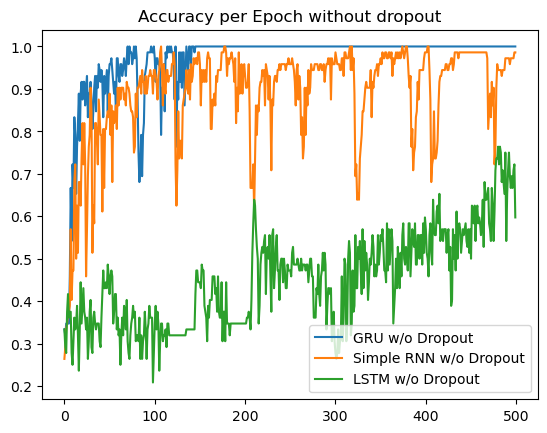

In [353]:
plt.plot(history4.history['categorical_accuracy'])
plt.plot(history5.history['categorical_accuracy'])
plt.plot(history6.history['categorical_accuracy'])

plt.legend(['GRU w/o Dropout', 'Simple RNN w/o Dropout', 'LSTM w/o Dropout'])
plt.title('Accuracy per Epoch without dropout')

Text(0.5, 1.0, 'Validation Accuracy per Epoch with dropout')

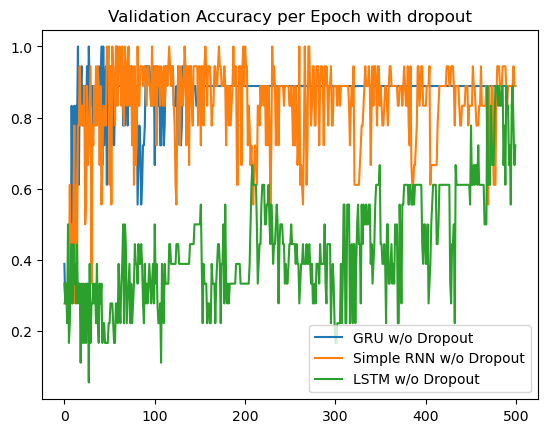

In [354]:
plt.plot(history4.history['val_categorical_accuracy'])
plt.plot(history5.history['val_categorical_accuracy'])
plt.plot(history6.history['val_categorical_accuracy'])

plt.legend(['GRU w/o Dropout', 'Simple RNN w/o Dropout', 'LSTM w/o Dropout'])
plt.title('Validation Accuracy per Epoch with dropout')

Text(0.5, 1.0, 'loss per Epoch without dropout')

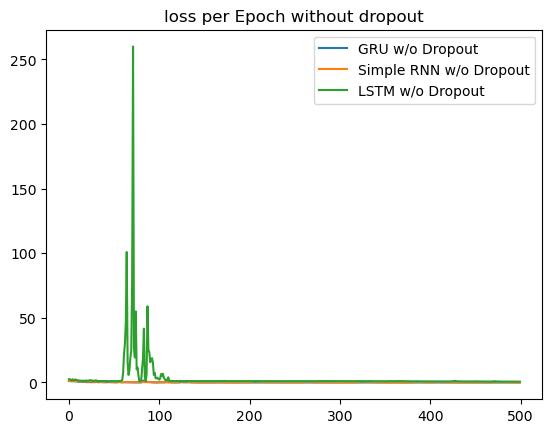

In [355]:
plt.plot(history4.history['loss'])
plt.plot(history5.history['loss'])
plt.plot(history6.history['loss'])

plt.legend(['GRU w/o Dropout', 'Simple RNN w/o Dropout', 'LSTM w/o Dropout'])
plt.title('loss per Epoch without dropout')

# 6. Save Weights

In [276]:
model.save('model1.h5')
model2.save('model2.h5')
model3.save('model3.h5')
model4.save('model4.h5')
model5.save('model5.h5')
model6.save('model6.h5')

# 7. Confusion Matrix

1/1 [==============================] - 0s 336ms/step


<AxesSubplot: title={'center': 'GRU Validation Confusion Matrix with dropout'}>

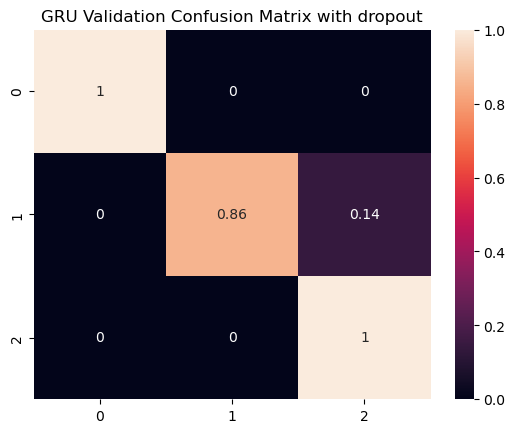

In [360]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
# Manually create a 3x3 confusion matrix
conf_matrix = confusion_matrix(ytrue, yhat, labels=[0, 1, 2])
# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
# Convert to DataFrame for easier plotting
df_conf_norm = pd.DataFrame(conf_matrix_norm, index=[0, 1, 2], columns=[0, 1, 2])

plt.title('GRU Validation Confusion Matrix with dropout')
sn.heatmap(df_conf_norm, annot=True)


1/1 [==============================] - 0s 151ms/step


<AxesSubplot: title={'center': 'Simple RNN Validation Confusion Matrix with dropout'}>

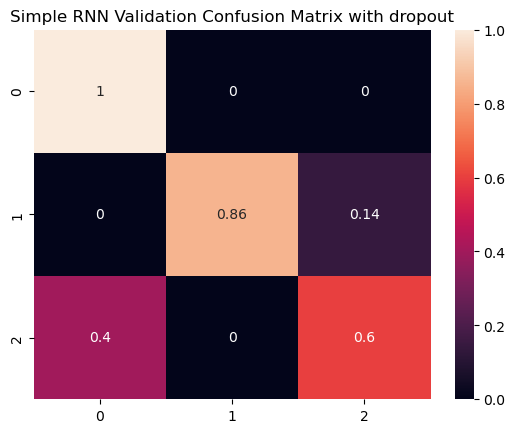

In [361]:
yhat = model2.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
# Manually create a 3x3 confusion matrix
conf_matrix = confusion_matrix(ytrue, yhat, labels=[0, 1, 2])
# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
# Convert to DataFrame for easier plotting
df_conf_norm = pd.DataFrame(conf_matrix_norm, index=[0, 1, 2], columns=[0, 1, 2])

plt.title('Simple RNN Validation Confusion Matrix with dropout')
sn.heatmap(df_conf_norm, annot=True)


1/1 [==============================] - 0s 240ms/step


<AxesSubplot: title={'center': 'LSTM Validation Confusion Matrix with dropout'}>

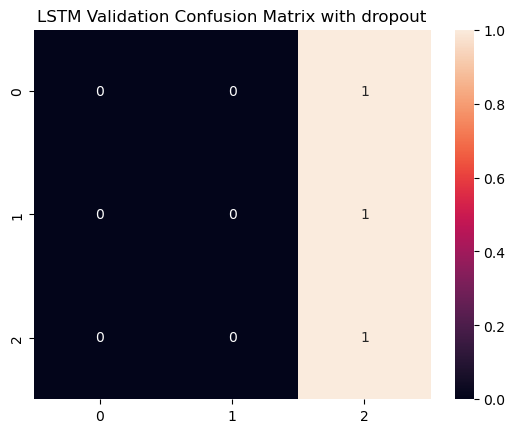

In [366]:
yhat = model3.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
# Manually create a 3x3 confusion matrix
conf_matrix = confusion_matrix(ytrue, yhat, labels=[0, 1, 2])
# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
# Convert to DataFrame for easier plotting
df_conf_norm = pd.DataFrame(conf_matrix_norm, index=[0, 1, 2], columns=[0, 1, 2])

plt.title('LSTM Validation Confusion Matrix with dropout')
sn.heatmap(df_conf_norm, annot=True)


1/1 [==============================] - 0s 415ms/step


<AxesSubplot: title={'center': 'GRU Validation Confusion Matrix without dropout'}>

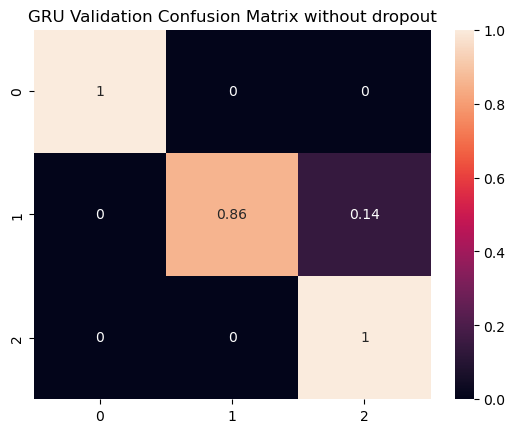

In [363]:
yhat = model4.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
# Manually create a 3x3 confusion matrix
conf_matrix = confusion_matrix(ytrue, yhat, labels=[0, 1, 2])
# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
# Convert to DataFrame for easier plotting
df_conf_norm = pd.DataFrame(conf_matrix_norm, index=[0, 1, 2], columns=[0, 1, 2])

plt.title('GRU Validation Confusion Matrix without dropout')
sn.heatmap(df_conf_norm, annot=True)


1/1 [==============================] - 0s 284ms/step


<AxesSubplot: title={'center': 'Simple RNN Validation Confusion Matrix without dropout'}>

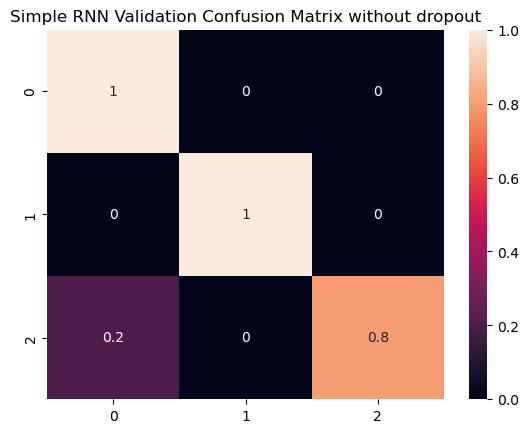

In [364]:
yhat = model5.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
# Manually create a 3x3 confusion matrix
conf_matrix = confusion_matrix(ytrue, yhat, labels=[0, 1, 2])
# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
# Convert to DataFrame for easier plotting
df_conf_norm = pd.DataFrame(conf_matrix_norm, index=[0, 1, 2], columns=[0, 1, 2])

plt.title('Simple RNN Validation Confusion Matrix without dropout')
sn.heatmap(df_conf_norm, annot=True)


1/1 [==============================] - 0s 368ms/step


<AxesSubplot: title={'center': 'LSTM Validation Confusion Matrix without dropout'}>

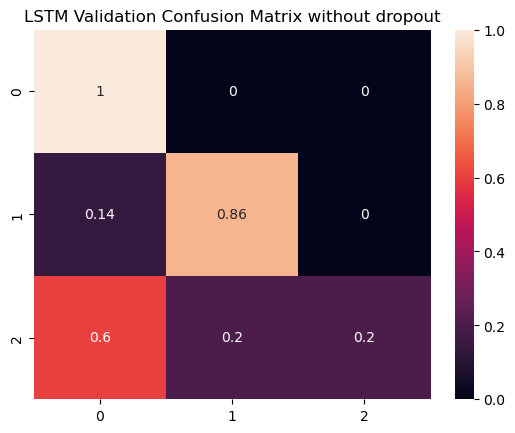

In [365]:
yhat = model6.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
# Manually create a 3x3 confusion matrix
conf_matrix = confusion_matrix(ytrue, yhat, labels=[0, 1, 2])
# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
# Convert to DataFrame for easier plotting
df_conf_norm = pd.DataFrame(conf_matrix_norm, index=[0, 1, 2], columns=[0, 1, 2])

plt.title('LSTM Validation Confusion Matrix without dropout')
sn.heatmap(df_conf_norm, annot=True)


# Inferencing Time

In [391]:
res = model.predict(X_test)

1/1 [==============================] - 0s 226ms/step


In [382]:
res = model2.predict(X_test)

1/1 [==============================] - 0s 146ms/step


In [383]:
res = model3.predict(X_test)

1/1 [==============================] - 0s 204ms/step


In [384]:
res = model4.predict(X_test)

1/1 [==============================] - 0s 284ms/step


In [385]:
res = model5.predict(X_test)

1/1 [==============================] - 0s 155ms/step


In [388]:
res = model6.predict(X_test)

1/1 [==============================] - 0s 243ms/step


# 8. Test in Real Time

In [333]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()